In [1]:
import Pkg; Pkg.activate("C:/Users/s151781/AppData/Local/Julia-1.3.1/GN/Project.toml")
using Revise
using Distributions
using PyPlot
using FFTW
using Compat
using WAV
using DSP
using Base64
using ForneyLab
using LinearAlgebra
using ProgressMeter

include("../functions/auxiliary/audioplayer.jl")
include("../functions/auxiliary/workflow.jl")
include("../functions/auxiliary/fourier.jl")
include("../functions/auxiliary/visualization.jl")
include("../functions/auxiliary/buffer.jl")
include("../functions/preprocessing.jl")

Activating environment at `C:\Users\s151781\AppData\Local\Julia-1.3.1\GN\Project.toml`


fft_expand (generic function with 1 method)

In [2]:
mutable struct AutoregressiveFilterbank <: ForneyLab.SoftFactor
    id::Symbol
    interfaces::Vector{Interface}
    i::Dict{Symbol,Interface}

    function AutoregressiveFilterbank(y, x, θ, w; id=ForneyLab.generateId(AutoregressiveFilterbank))
        
        # ensure that the input arguments are random variables
        @ensureVariables(y, x, θ, w) 
        
        # create new object
        self = new(id, Array{Interface}(undef, 4), Dict{Symbol,Interface}())
        
        # add the node to the current factor graph
        ForneyLab.addNode!(currentGraph(), self)
        
        # add argument variables to interfaces of node
        self.i[:y] = self.interfaces[1] = ForneyLab.associate!(Interface(self), y)
        self.i[:x] = self.interfaces[2] = ForneyLab.associate!(Interface(self), x)
        self.i[:θ] = self.interfaces[3] = ForneyLab.associate!(Interface(self), θ)
        self.i[:w] = self.interfaces[4] = ForneyLab.associate!(Interface(self), w)
        
        # return object
        return self
    end
end

In [3]:
# add shortcut for calling the filter bank
slug(::Type{AutoregressiveFilterbank}) = "ARFB"

slug (generic function with 1 method)

In [4]:
function ruleVariationalARFBOutNPPP(marg_y::Nothing, 
                                    marg_x::ProbabilityDistribution{ForneyLab.Multivariate}, 
                                    marg_θ::ProbabilityDistribution{ForneyLab.Multivariate}, 
                                    marg_w::ProbabilityDistribution{ForneyLab.MatrixVariate})

    # calculate required means
    mθ = ForneyLab.unsafeMean(marg_θ)
    mx = ForneyLab.unsafeMean(marg_x)
    mw = ForneyLab.unsafeMean(marg_w)
                        
    # calculate new parameters
    my = mθ .* mx
    wy = mw

    # create variational message
    return Message(ForneyLab.Multivariate, GaussianWeightedMeanPrecision, xi=wy*my, w=wy)

end

ruleVariationalARFBOutNPPP (generic function with 1 method)

In [5]:
function ruleVariationalARFBIn1PNPP(marg_y::ProbabilityDistribution{ForneyLab.Multivariate}, 
                                    marg_x::Nothing, 
                                    marg_θ::ProbabilityDistribution{ForneyLab.Multivariate}, 
                                    marg_w::ProbabilityDistribution{ForneyLab.MatrixVariate})
    
    # caluclate required means
    my = ForneyLab.unsafeMean(marg_y)
    mθ = ForneyLab.unsafeMean(marg_θ)
    mw = ForneyLab.unsafeMean(marg_w)

    # calculate required variances
    vθ = ForneyLab.unsafeCov(marg_θ)

    # calculate new parameters
    wx = (vθ' + mθ*mθ') .* mw
    #mx = inv(wx) * Diagonal(mθ) * mw * my
    xix = Diagonal(mθ) * mw' * my
    
    # create variational message
    return Message(ForneyLab.Multivariate, GaussianWeightedMeanPrecision, xi=xix, w=wx)

end

ruleVariationalARFBIn1PNPP (generic function with 1 method)

In [6]:
function ruleVariationalARFBIn2PPNP(marg_y::ProbabilityDistribution{ForneyLab.Multivariate}, 
                                    marg_x::ProbabilityDistribution{ForneyLab.Multivariate}, 
                                    marg_θ::Nothing, 
                                    marg_w::ProbabilityDistribution{ForneyLab.MatrixVariate})

    # calculate required means
    my = ForneyLab.unsafeMean(marg_y)
    mx = ForneyLab.unsafeMean(marg_x)
    mw = ForneyLab.unsafeMean(marg_w)

    # calculate required variances
    vx = ForneyLab.unsafeCov(marg_x)

    # calculate new parameters
    wθ = (vx' + mx*mx') .* mw
    #mθ = inv(wθ) * Diagonal(mx) * mw' * my
    xiθ = Diagonal(mx) * mw' * my
    
    # create variational message
    Message(ForneyLab.Multivariate, GaussianWeightedMeanPrecision, xi=xiθ, w=wθ)

end

ruleVariationalARFBIn2PPNP (generic function with 1 method)

In [7]:
function ruleVariationalARFBIn3PPPN(marg_y::ProbabilityDistribution{ForneyLab.Multivariate}, 
                                    marg_x::ProbabilityDistribution{ForneyLab.Multivariate}, 
                                    marg_θ::ProbabilityDistribution{ForneyLab.Multivariate}, 
                                    marg_w::Nothing)

    # calculate required means
    my = ForneyLab.unsafeMean(marg_y)
    mx = ForneyLab.unsafeMean(marg_x)
    mθ = ForneyLab.unsafeMean(marg_θ)

    # calculate required variances
    vy = ForneyLab.unsafeCov(marg_y)
    vx = ForneyLab.unsafeCov(marg_x)
    vθ = ForneyLab.unsafeCov(marg_θ)

    # calculate new parameters
    v = vy + my*my' - (mθ .* mx)*my' - my*(mx .* mθ)' + Diagonal(mθ)*vx*Diagonal(mθ) + Diagonal(mx)*vθ*Diagonal(mx)  + (mθ .* mx)*(mθ .* mx)' + vθ.*vx
    nu = size(v,1) + 2 

    # create variational message
    Message(ForneyLab.MatrixVariate, ForneyLab.Wishart, v=inv(v), nu=nu)

end

ruleVariationalARFBIn3PPPN (generic function with 1 method)

In [8]:
@naiveVariationalRule(:node_type     => AutoregressiveFilterbank,
                      :outbound_type => Message{GaussianWeightedMeanPrecision},
                      :inbound_types => (Nothing, ProbabilityDistribution, ProbabilityDistribution, ProbabilityDistribution),
                      :name          => VariationalARFBOutNPPP)

@naiveVariationalRule(:node_type     => AutoregressiveFilterbank,
                      :outbound_type => Message{GaussianWeightedMeanPrecision},
                      :inbound_types => (ProbabilityDistribution, Nothing, ProbabilityDistribution, ProbabilityDistribution),
                      :name          => VariationalARFBIn1PNPP)

@naiveVariationalRule(:node_type     => AutoregressiveFilterbank,
                      :outbound_type => Message{GaussianWeightedMeanPrecision},
                      :inbound_types => (ProbabilityDistribution, ProbabilityDistribution, Nothing, ProbabilityDistribution),
                      :name          => VariationalARFBIn2PPNP)

@naiveVariationalRule(:node_type     => AutoregressiveFilterbank,
                      :outbound_type => Message{ForneyLab.Wishart},
                      :inbound_types => (ProbabilityDistribution, ProbabilityDistribution, ProbabilityDistribution, Nothing),
                      :name          => VariationalARFBIn3PPPN)


In [9]:
function generateARFB(nr_γ, bufsize)
    
    model = quote
        
        fg = FactorGraph()
        
        @RV [id=:smin] smin ~ GaussianMeanVariance(placeholder(:μ_smin, dims=(2*$nr_γ,)), placeholder(:Σ_smin, dims=(2*$nr_γ,2*$nr_γ)))
        @RV [id=:θ] θ ~ GaussianMeanVariance(placeholder(:μ_θ, dims=(2*$nr_γ,)), placeholder(:Σ_θ, dims=(2*$nr_γ,2*$nr_γ)))
        @RV [id=:w] w ~ ForneyLab.Wishart(placeholder(:v_w, dims=(2*$nr_γ,2*$nr_γ)), placeholder(:nu_w))
        @RV [id=:s] s ~ AutoregressiveFilterbank(smin, θ, w)
        @RV [id=:x] x = placeholder(:c, dims=($bufsize,2*$nr_γ)) * s
        @RV [id=:y] y ~ GaussianMeanVariance(x, placeholder(:Σ_x, dims=($bufsize,$bufsize)))
        placeholder(y, :y, dims=($bufsize,))
        
        q = PosteriorFactorization(smin, s, θ, w, ids=[:smin, :s, :θ, :w])

    end
    
end

generateARFB (generic function with 1 method)

In [10]:
# load speech data
xi, fs = wavread("../data/airco.wav", format="native")
fs = Int(fs)
xi = convert(Array{Float64,1}, xi[1*fs:4*fs])

# pre-process signals
yi = preprocess(xi, fs, fs_desired=2000) 

N = length(yi)
t = collect(1:N)/2000
fs = 2000
nr_freqs = 39

audioplayers(yi, fs=2000);

<source src="data:audio/wav;base64,UklGRgBeAABXQVZFZm10ICgAAAD+/wEA0AcAAEAfAAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YcRdAAAnrw0+HgPhPj7yBD/6y+g+fpKtPj48pj6Mu/s9p5L4vWg3Vr29TO+95rHEvsCaq76D/de+PFYJvwD0mb47Oje+FR8KviyLMr6+IsY9zTYBPrslvT6Q2vY+6sMrPwQ1Jz+cWvE+E42rPtiABz7oD9G9l6Gkvjm3xr7H6/K+VCC4vorPf77ewo6+7VhSvsAX6b6ursi+kp2fvhmug75A/9M8qxCaPt3h+z7diB8/jgArP2y93z6AXDE/FtwEP9Pakj5W0WQ8ICeVvisZEL8+8yC/Cz42v1OrDr/x69a+XAOGvqPeQr7t2Gi9Dm/QuwvmZj1QVjg+qwTZPpL73z4q5bA+0DHPPiNAgT53snY+WgJ1Puo4gz6mGAY9bgVnvHW11b3rUqy+gdUYv0AqOL/+SCm/wGWyvmyi2b3dhEY+pSxUPpDmgz7nN2Q+XEFIPpjExD7456s+UgXCPj/6oD687zk+C2EXPhb8az2m3oi9cNvkvdglO77bhti+7K8Lv3VrPr/fB2S/z1wKv5RDk75weJI+Iy7hPh9iED9UMBk/tfUNP250Bj/S6cM+Qze5Pvq1jT5Ow4s+3i/vvF1fjr7bn6m+I4Env1k6C7+x3PO+lwTwvi3Ai74HJAy+fJQHvtCUDj0LZxQ+JHSkPQb2lz4n2AQ/flwRP3TW8T6CEyA/00L1PsGcrT4rrkI8kKSUvhzNBL/hdTO/e4ddv6ByCb/THOe+y5Fevu5t3b1DjDq9C38JPja0iD5T0/s+QGiPPsDIsj5hWqQ+xLToPrEsGj8/ONw+I63nPhxREz5Uos28NsWGvZsQAr+diy2/CNQVvxCIP78Ryka/O+z8vo2uxb6kzC6+eDtLPncpsj7HCLY+zDTePkqjXD6l9Hc+ToW/PpF+Vz5HtN8++YCAPgZy4T1JezS9H5I1vt/WB7/nc+a+FpgFv2Vj0b5NKxG+UFt4Pj+sJT4Tv5M+zJKbPiAMlj54r4s+/VSnPtuNrj2hFEY+7IU6Pngxtz2y16q9f+ITvlIomb6ncYK+hi/evqKb176hNAG/cqMpv2h0pL6RUS2+2j49PbzMwT6LL+A+217hPrE39D6uWoo+jUWhPoQnyz4jwpI+krHvPRa9UT4Drki+WSE1vsOo6zya/Ym+iUp/voYPV76wq96+BaqbvjyE674dAsi+kzlQvk70ZD6Bn8E+wFPPPq878D4Fa70+E2WUPqmfiz4qO/g8V+WDvfkhKr4lGcu+6RipvjTQmL4dclq+xjsPvpIrXL2IMTw9KxCBPdolhz4Gpys+jwdsPcQHaDwQ15w+VlEFP3zzDj5nQ0c+FKE9PSVFBr51t7o9p5ISvs826L7wyt++A6nSvsKZH7+Xbpu+q2UCvk+szT3mNL0+NzASP4JC6D5iGgE//cEJPjrYDT0ypKY8JKlYPjlEWD4aISE+z9PzvabZnL7+Xee+04sVvvWPvb3F+km+9vL8vbDdqr7XG+a+A4iQvlsnH753d6I9ZuqMPrWa2T7T8ew+qjLTPqTaEj51rYc+ECfLPvq4jj4hn9U9kkoRvnxfbL7d3ta+eqv9vvBl876JJ96+m59rvnVlYDwyUxC+QxQCvsjfjryst+o98wRJPpqL3z4GnKY+K+4yPtXolT5QPaQ+rjSBPsZDNT4UO+k9KT3zvCg1Sr6mPJa+1suqvmwnxb7yjJu+cuBNvpdKb73isRA+KP4pvf/h870AQca9cQLVveMHnj7npI4+V6KVPl6uiT5VZ00+rH9cPgPIhD0d8809OJ08vu/QE76ew4G+Jiedvh7Qm77+YpW+aBNtvhCnlr2sesw9aGKAPugMcL1jHY09mFezPI4tYD7v7g0/EtfqPvtcYT7jXUk++28Avsi2O75Rihm+dKInvlFXAL8c1RC/BwwHv6AJxb6YEAK+H5fPPcnumD4XGv4+O9UWPxigkj5v25c9y0o7vn0mHr1GaEI+fCbsPtNjbj7/4/A9htCkPHsaG742yxi98QcuvkMxzL5KDhG/QOUiv0cmDb+9CoC+1QRjPsCOzz720Qw/T+fAPrUX4D5o03k+tG0ePIC3VL48pZy+HBBUvrQXLz1UMxU9KOrVPdYKjz3a74K+4YMkPAlz4b0czN68XNa1vV1BFb5CZei97iPPvZdsQD2V8Tg+Mu3hPuWHAT+ZHes+U6r7Pd82sD188sS9chPDvlR8pr4ou1q+vacpvkMtR77ut6q+UA4Kv3NTib4VxyQ8+z98PhJFAj9ooSY+/ifkPWCeu70hYp09qC6GPgUvtj4/Nao+vsIhPqSRyz2ST6E8y73ZvUNwlT1ZZ16+Kzu9vkpDFb9H6IW+FpDJvuSv/L43WLG8vp+JPshZIT+RF1M/f8TpPnEIJbxzXgu+ymIfvtfSjL0mDog9kyLhvKkMA763NqW8ihWrPDOGXj0kxDA+6plLvlj2qL5UMai+3t6hvk6DS74Bjxi+pg5RPqXNdz60pdw+cj/1Pjc/JT4Ne9C9ZuyNvod7s75LTlW9+4N7PjLHZT5e7AQ96KbfvTIBwL39RZ++tcs/vnBQH74gqeO976iIvtpYaL2isg4+GUfEPtoAFD9H29A+HgjYPnAhvD5yADG+kVZkvmWY5b4aodS+J32Kve+7jz5dvmI+f5Pyu3P0E77X7gq/9ijnvk1MIr69pxG+22QqPSj5vD1m79E9z/5APiN8Dj6N2p8+tv+yPaOWZT7wip0+9bMfPQax5708A5i9epmIvqCgc73aiPA9MlO3vD+IJb7cug6+EW7Dvk3/674V4uy6+PSbPmCvAz8dhf4+u5ZNPhPsR71a6o++uxuQvtLzF77oNaG6LJZ9PmEIiT6TCqM+mf8EvjBcwb7RQqi+zzmOvp0XVb6tJMS9mHs+vvvOdr6d6AY9F++kPmWt5T4BDCo/LmfgPqZBXz4265E8SYKcvZNaOL6hwf29o+czvmocQr3mD828hZG7vfxNUr6lhcy+TASovlP2mb5n5z69QrMGPkDTsj7Wwbg98yNSPshvDT5mcyE+uJY3Pv+kQz7Qllk9BuH5PZmmsL2Q+yK+/xZivn4Gqb4whzW+zBjIvViwzTuhOY49SNyRPQgu8rytT6S9YOYAvfJBDD4ylrI+4qS9PlmXiD0co6G8I1X3PYS+Gj5tYwM930PwvIa1Yr3kPQi+viqAvjvQhr446+W+DTgYvmErkL73TN08+l6WPl5wxz0584W9fop1vLaU4ruY19I9NlvPPluHjT4vmVg+NdIWPavgS74/f+y8jD69PTusEL2ynQQ+ZqhIvXUbq77Xrke+TlWYvqW4fb5Asxy8Ybs3Pmizsj4BHrA+8MLLPYczt72FDZW77NpovHvkpT49O+49WZvDPQDQEr6znL6+dwjFvoOEO75f3CO+YvsgvgsjbDzrbpI8i0e7PVYhHj3PRRk+vg+8PVIObz45PFI93R7rPbV3sL336JW9PJH1vdmvfD2jjxU+DJBsPvPIUz7Ed9q9HmSavY9Cv72Rj9O+9SZ5vrGXu70J0py9QRqaPc9EoT2Tk2S9TCgBPqk5gj434o0+4R3bPjmSrj4k3bo9V47NvQw8jb4Retu+BNmkvfhJ3L1SpOo9fxrzvYMzwb4JmtG+tZOKvj32V75hHEo+3U0VP0YTvT4dK7w+pY02PpfT6bygwti8rRdHPk5Jxz4IeIU+NfoBPpZAZL4QEAK/ew39vk1oor4KcQO+iHSSPfoZer3QtLS+z5WmvtTMyb4/L2S98HCDPvxqHD9XdyY/WGoOP9Vg2D0+MDq9g436vdwoab5brSO+dGmsPJEaqT19smO909+hvY0WHr6EdHO9Mg4YvSD0Wz18ni2+r3qlvltkYL5erFS+2KfnPQQn4z6pmxg/s6EOP1xh4D6+l

In [11]:
f = collect(fs/2/(nr_freqs+1):fs/2/(nr_freqs+1):fs/2)#-fs/2/(nr_freqs+1))
f = (exp.(f/fs/2).-1)*(fs/2/(exp.(f[end]/fs/2).-1))
bufsize = 2*(nr_freqs+1)
stepsize = 1

# create fg
eval(generateARFB(nr_freqs, bufsize))
ForneyLab.draw(fg)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.38.0 (20140413.2041)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 3497596842101853536 -->
 3497596842101853536 
 
 placeholder_c 
 
<!-- 364515301021909809 -->
 364515301021909809 
 
 placeholder_y 
 
<!-- 16021903690613715675 -->
 16021903690613715675 
 
 𝒩 
 gaussianmeanvariance_3 
 
<!-- 364515301021909809--16021903690613715675 -->
 364515301021909809--16021903690613715675 
 
 y 
 1 out 
 1 out 
 
<!-- 4619893013529989425 -->
 4619893013529989425 
 
 𝒩 
 gaussianmeanvariance_1 
 
<!-- 1392890949305407581 -->
 1392890949305407581 
 
 placeholder_Σ_smin 
 
<!-- 4619893013529989425--1392890949305407581 -->
 4619893013529989425--1392890949305407581 
 
 Σ_smin 
 1 out 
 3 v 
 
<!-- 4911908607451682137 -->
 4911908607451682137 
 
 placeholder_μ_smin 
 
<!-- 4619893013529989425--4911908607451682137 -->
 4619893013529989425--4911908607451682137 
 
 μ_smin 
 1 out 
 2 m 
 
<!-- 11155924613519161875 -->
 11155924613519161875 
 
 placeholder_Σ_θ 
 
<!-- 12104025793323604316 -->
 12104025793323604316 
 
 𝒩 
 gaussianmeanvariance_2 
 
<!-- 12104025793323604316--11155924613519161875 -->
 12104025793323604316--11155924613519161875 
 
 Σ_θ 
 1 out 
 3 v 
 
<!-- 8026859618439227154 -->
 8026859618439227154 
 
 placeholder_μ_θ 
 
<!-- 12104025793323604316--8026859618439227154 -->
 12104025793323604316--8026859618439227154 
 
 μ_θ 
 1 out 
 2 m 
 
<!-- 6988291675867243280 -->
 6988291675867243280 
 
 W 
 wishart_1 
 
<!-- 8026368345047266259 -->
 8026368345047266259 
 
 placeholder_v_w 
 
<!-- 6988291675867243280--8026368345047266259 -->
 6988291675867243280--8026368345047266259 
 
 v_w 
 1 out 
 2 v 
 
<!-- 10442741144744489295 -->
 10442741144744489295 
 
 placeholder_nu_w 
 
<!-- 6988291675867243280--10442741144744489295 -->
 6988291675867243280--10442741144744489295 
 
 nu_w 
 1 out 
 3 nu 
 
<!-- 12357234989845276771 -->
 12357234989845276771 
 
 × 
 multiplication_1 
 
<!-- 12357234989845276771--3497596842101853536 -->
 12357234989845276771--3497596842101853536 
 
 c 
 1 out 
 3 a 
 
<!-- 1059727937435960515 -->
 1059727937435960515 
 
 AutoregressiveFilterbank 
 autoregressivefilterbank_1 
 
<!-- 12357234989845276771--1059727937435960515 -->
 12357234989845276771--1059727937435960515 
 
 s 
 1 y 
 2 in1 
 
<!-- 1151439321031454577 -->
 1151439321031454577 
 
 placeholder_Σ_x 
 
<!-- 1059727937435960515--4619893013529989425 -->
 1059727937435960515--4619893013529989425 
 
 smin 
 1 out 
 2 x 
 
<!-- 1059727937435960515--12104025793323604316 -->
 1059727937435960515--12104025793323604316 
 
 θ 
 1 out 
 3 θ 
 
<!-- 1059727937435960515--6988291675867243280 -->
 1059727937435960515--6988291675867243280 
 
 w 
 1 out 
 4 w 
 
<!-- 16021903690613715675--12357234989845276771 -->
 16021903690613715675--12357234989845276771 
 
 x 
 1 out 
 2 m 
 
<!-- 16021903690613715675--1151439321031454577 -->
 16021903690613715675--1151439321031454577 
 
 Σ_x 
 1 out 
 3 v

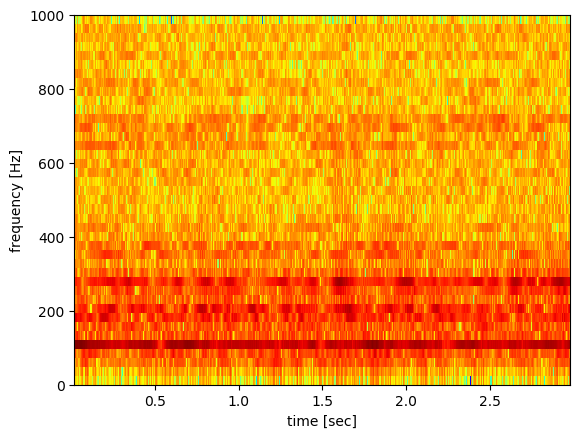

In [12]:
plot_spectrogram(spectrogram(yi, bufsize, bufsize-stepsize, fs=fs), fs)

In [13]:
# generate algorithm
algo = variationalAlgorithm(q)
source_code = compatibility_fix(algorithmSourceCode(algo))
eval(Meta.parse(source_code))
println(source_code)

begin

function stepw!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 2))

messages[1] = ruleVBWishartOut(nothing, ProbabilityDistribution(MatrixVariate, PointMass, m=data[:v_w]), ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=data[:nu_w]))
messages[2] = ruleVariationalARFBIn3PPPN(marginals[:s], marginals[:smin], marginals[:θ], nothing)

marginals[:w] = messages[1].dist * messages[2].dist

return marginals

end

function steps!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 4))

messages[1] = ruleVariationalARFBOutNPPP(nothing, marginals[:smin], marginals[:θ], marginals[:w])
messages[2] = ruleSPMultiplicationOutNGP(nothing, messages[1], Message(MatrixVariate, PointMass, m=data[:c]))
messages[3] = ruleVBGaussianMeanVarianceM(ProbabilityDistribution(ForneyLab.Multivariate, PointMass, m=data[:y]), nothing, ProbabilityDistribution(MatrixVariate, PointMass, m=data[:Σ_x]))
messages[4] = ruleSPMultiplication

In [14]:
function AR_PSD(θ::Array{Float64,1}, ω::Float64, ρ::Float64, σ2::Float64)::Array{Float64,1}
    return σ2 ./ (1 .+ ρ^2 .- 2*ρ*cos.(θ.-ω))
end

function sum_AR_PSD(θ::Array{Float64,1}, ω::Array{Float64,1}, ρ::Array{Float64,1}, σ2::Array{Float64,1})::Array{Float64,1}
    return sum([AR_PSD(θ, ω[m], ρ[m], σ2[m]) for m = 1:length(ω)])
end

sigmoid(x) = 1 ./ (1 .+ exp.(-x))
dsigmoid(x) = sigmoid(x).*(1 .- sigmoid(x))

function logMSE(y::Array{Float64,2}, θ::Array{Float64,1}, ω::Array{Float64,1}, ρ::Array{Float64,1}, σ2::Array{Float64,1})::Float64
    
    # calculate number of AR components
    M = length(ω)
    
    # calculate number of data points
    N = size(y,2)
    
    # calculate MSE
    mse = mean( abs2.(y' .- log.(sum_AR_PSD(θ, ω, ρ, σ2))))
    
    # return MSE
    return mse
    
end

function ∇α_logMSE(y::Array{Float64,2}, θ::Array{Float64,1}, ω::Array{Float64,1}, ρ::Array{Float64,1}, σ2::Array{Float64,1})::Array{Float64}
        
    # calculate number of AR components
    M = length(ω)
    
    # calculate number of data points
    N = size(y,2)
    
    # calculate gradient
    grad = -2 / N * squeeze(sum((y' .- log.(sum_AR_PSD(θ, ω, ρ, σ2))), dims=2))'*(1 ./ sum_AR_PSD(θ, ω, ρ, σ2) .* hcat([AR_PSD(θ, ω[m], ρ[m], σ2[m]) for m=1:length(ω)]...))

    # return gradient
    return squeeze(grad)
end

function ∇β_logMSE(y::Array{Float64,2}, θ::Array{Float64,1}, ω::Array{Float64,1}, ρ::Array{Float64,1}, σ2::Array{Float64,1})::Array{Float64}
        
    # calculate number of AR components
    M = length(ω)
    
    # calculate number of data points\omega[1]
    N = size(y,2)
    
    # calculate gradient
    grad = - 2 / N * squeeze(sum((y' .- log.(sum_AR_PSD(θ, ω, ρ, σ2))), dims=2))'*(1 ./ sum_AR_PSD(θ, ω, ρ, σ2) .* ( σ2 ./ (1 .+ ρ.^2 .- 2*ρ.*cos.(θ'.-ω)).^2)' .* (2*ρ.*sin.(θ'.-ω))' .* (ω.*(1 .- ω/π))')
    
    # return gradient
    return squeeze(grad)
end

function ∇γ_logMSE(y::Array{Float64,2}, θ::Array{Float64,1}, ω::Array{Float64,1}, ρ::Array{Float64,1}, σ2::Array{Float64,1})::Array{Float64}
        
    # calculate number of AR components
    M = length(ω)
    
    # calculate number of data points
    N = size(y,2)
    
    # calculate gradient
    grad =  2 / N * squeeze(sum((y' .- log.(sum_AR_PSD(θ, ω, ρ, σ2))), dims=2))'*(1 ./ sum_AR_PSD(θ, ω, ρ, σ2) .* (σ2 ./ (1 .+ ρ.^2 .- 2*ρ.*cos.(θ'.-ω)).^2)' .* (2*ρ .-2*cos.(θ'.-ω))' .* (ρ.*(1 .- ρ))')
    
    # return gradient
    return squeeze(grad)
end
function Adam(θ::Array{Float64,1}, ∇::Array{Float64,1}, s::Array{Float64,1}, r::Array{Float64,1}, it::Int64; η=0.001::Float64, ρ1=0.9::Float64, ρ2=0.999::Float64, δ=1e-7::Float64)
    
    # update first moment
    s = ρ1*s + (1-ρ1)*∇
    
    # update second moment
    r = ρ2*r + (1-ρ2)*∇.*∇
    
    # perform bias correction
    sx = s / (1 - ρ1^it)
    rx = r / (1 - ρ2^it)
    
    # update parameters
    θ = θ - η./(δ .+ sqrt.(rx)) .* sx
    
    return θ, s, r
end
;

In [15]:
freqres = 100
smooth = 100
psd = twosided2singlesided(PSDovertime(yi, freqres*2, freqres*2-1, rectangularwindow))[:,:]
log_psd_smooth = vcat([log.(mean(psd[k:k+smooth,:], dims =1)) for k = 1:size(psd,1)-smooth]...)[:,:]
;

In [16]:
L = size(log_psd_smooth, 2) # length of data
M = nr_freqs # nr_clusters
N = size(log_psd_smooth, 1) # data points

# initializers
θ = collect(0:π/L:π - π/L)
ρ = rand(M)/100 .+0.99 # in range 0.9-1.0
σ2 = 10*rand(M)
α = log.(σ2)
ω = collect(π/(M+1):π/(M+1):π-π/(M+1)+0.0001)
β = -log.(π./ω .- 1)
γ = -log.(1 ./ ρ .-1)

# initializers:
s_α = zeros(M)
r_α = zeros(M)
s_β = zeros(M)
r_β = zeros(M)
s_γ = zeros(M)
r_γ = zeros(M)

# optimization
nits = 5000
η1 = 0.001
η2 = 0.00001
η3 = 0.00001

p = Progress(nits)

batches = 50
step = Int(floor(size(log_psd_smooth,1)/batches))

for it = 1:nits
    for b = 1:batches
        α, s_α, r_α = Adam(α, ∇α_logMSE(log_psd_smooth[(b-1)*step+1:b*step, :], θ, ω, ρ, σ2), s_α, r_α, it, η=η1)
        σ2 = exp.(α)
        β, s_β, r_β = Adam(β, ∇β_logMSE(log_psd_smooth[(b-1)*step+1:b*step, :], θ, ω, ρ, σ2), s_β, r_β, it, η=η2)
        ω = π*sigmoid.(β)
        γ, s_γ, r_γ = Adam(γ, ∇γ_logMSE(log_psd_smooth[(b-1)*step+1:b*step, :], θ, ω, ρ, σ2), s_γ, r_γ, it, η=η3)
        ρ = sigmoid(γ)
    end
    η1 = η1*0.99999
    η2 = η2*0.99999
    η3 = η3*0.99999
    mse = logMSE(log_psd_smooth, θ, ω, ρ, σ2)
    ProgressMeter.next!(p; showvalues = [(:it,it), (:mse,mse)])
    #next!(p)
end

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter C:\Users\s151781\.julia\packages\ProgressMeter\lMMY9\src\ProgressMeter.jl:454
Progress: 100%|█████████████████████████████████████████| Time: 0:10:06
  it:   5000
  mse:  0.5611573663191896


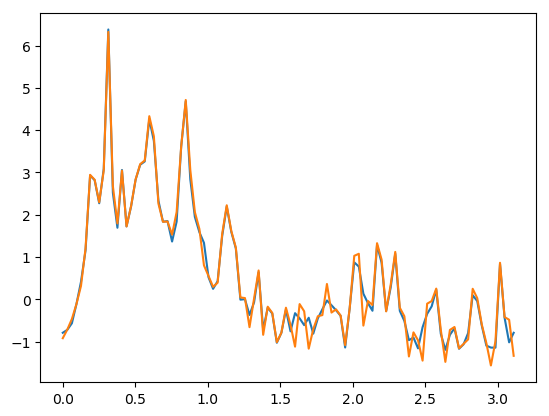

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000005FB30C88>

In [17]:
pred = log.(sum_AR_PSD(θ, ω, ρ, σ2) )
plt.plot(θ, squeeze(mean(log_psd_smooth, dims=1)))
plt.plot(θ, pred)


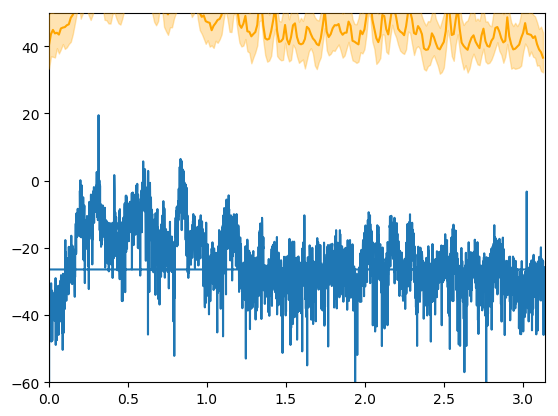

In [18]:
# generation:
Ni = 500 # (nr samples + frequency resolution)
Mi = 100 # nr of iterations

# get parameters ForneyLab.unsafeMean(marginals[:θ])
μ_θi, Σ_θi = repeat(ρ, inner=2), 0.0001*diagm(ones(2*nr_freqs))
v_wi, nu_wi = diagm(1 ./repeat(σ2, inner=2))/(2*nr_freqs), 2*nr_freqs

f = ω/2/π*fs

function generate1psd(μ_θi, Σ_θi, v_wi, nu_wi, N, fs, f)
    # create signal (option 1)
    sif = Array{Float64,2}(undef, 2*length(f), N)
    xif = Array{Float64,1}(undef, N)
    sif[:,1] = zeros(2*length(f))
    xif[1] = 0
    for n = 2:N
        θs = rand(MvNormal(μ_θi, collect(Hermitian(Σ_θi))))
        ws = rand(MvNormal(zeros(2*length(f)), collect(Hermitian(inv(rand(Distributions.Wishart(nu_wi, collect(Hermitian(v_wi)))))))))
        sif[:,n] = θs.*sif[:,n-1] + ws
        xif[n] = collect(sif[:,n]'*reshape( [cos.(2*pi*f/fs*n') sin.(2*pi*f/fs*n')]', 1, 2*length(f))')[1,1]
    end
    return xif
end

function approxpsd(M, μ_θi, Σ_θi, v_wi, nu_wi, N, fs, f)
    psd = Array{Float64,2}(undef, M, N) 
    for m = 1:M
        xif = generate1psd(μ_θi, Σ_θi, v_wi, nu_wi, N, fs, f)
        psd[m,:] = (abs.(FFTW.fft(xif)).^2)./length(xif)
    end
    return squeeze(10*log10.([quantile(psd[:,k], 0.5) for k = 1:N])), squeeze(10*log10.([quantile(psd[:,k], 0.25) for k = 1:N])), squeeze(10*log10.([quantile(psd[:,k], 0.75) for k = 1:N]))
end

mean_psd, std_psd1, std_psd2 = approxpsd(Mi, μ_θi, Σ_θi, v_wi, nu_wi, Ni, fs/stepsize, f)
mean_psd = mean_psd[1:Int(floor(Ni/2))]
std_psd1 = std_psd1[1:Int(floor(Ni/2))]
std_psd2 = std_psd2[1:Int(floor(Ni/2))]
plt.plot(FFTW.fftfreq(length(yi), fs)/fs*2*pi, 10*log10.((abs.(FFTW.fft(yi)).^2)./length(yi)))
plt.plot(abs.(FFTW.fftfreq(Ni, fs)[1:Int(floor(Ni/2))])/fs*2*pi, mean_psd, color="orange")
plt.fill_between(abs.(FFTW.fftfreq(Ni, fs)[1:Int(floor(Ni/2))])/fs*2*pi, std_psd1, std_psd2, color="orange", alpha=0.3, zorder=100)
plt.xlim(0,pi)
plt.ylim(-60,50)
;

In [19]:
duration_train = 3
nr_samples_train = Int((fs*duration_train-bufsize)/stepsize) + 1
signal_t = [yi[(ki-1)*stepsize+1:(ki-1)*stepsize+bufsize].*rectangularwindow(bufsize) for ki = 1:nr_samples_train];
t_t = [t[(ki-1)*stepsize+1:(ki-1)*stepsize+bufsize] for ki = 1:nr_samples_train];
    

In [41]:
N = nr_samples_train
μ_θ_mem = Array{Float64,2}(undef, N, 2*nr_freqs)
Σ_θ_mem = Array{Float64,2}(undef, N, 2*nr_freqs)
μ_s_mem = Array{Float64,2}(undef, N, 2*nr_freqs)
μ_x_mem = Array{Float64,1}(undef, nr_samples_train)
Σ_x_mem = Array{Float64,1}(undef, N)
v_w_mem = Array{Float64,2}(undef, N, 2*nr_freqs)
det_v_w_mem = Array{Float64,1}(undef, N)

# priors
μ_smin = zeros(2*nr_freqs)
Σ_smin = 100*Ic(2*nr_freqs)
μ_θ = repeat(ρ, inner=2)
Σ_θ = 0.001*diagm(ones(2*nr_freqs))
v_w = diagm(1 ./repeat(σ2, inner=2))/(2*nr_freqs)
nu_w = 2*nr_freqs
Σ_x = 1e-8*Ic(bufsize)

p = Progress(nr_samples_train)
marginals = Dict()

for n = 1:nr_samples_train
    
    next!(p)
    
    # fill marginals dictionary
    marginals[:smin] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanVariance, m=μ_smin, v=Σ_smin)
    marginals[:θ] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanVariance, m=μ_θ, v=Σ_θ)
    marginals[:w] = ProbabilityDistribution(ForneyLab.MatrixVariate, ForneyLab.Wishart, v=v_w, nu=nu_w)
    
    # fill data dictionary
    data = Dict()
    data[:μ_smin] = μ_smin
    data[:Σ_smin] = Σ_smin
    data[:μ_θ] = μ_θ
    data[:Σ_θ] = Σ_θ
    data[:v_w] = v_w
    data[:nu_w] = nu_w
    data[:c] = reshape( [cos.(2*pi*f*t_t[n]') sin.(2*pi*f*t_t[n]')]', bufsize, 2*nr_freqs)#cos.(2*pi*f*t[n-bufsize+1:n]')'
    data[:Σ_x] = Σ_x*Ic(bufsize)
    data[:y] = signal_t[n] .- mean(signal_t[n])
    
    # make prediction
    messages = Array{Message}(undef, 4)
    Base.invokelatest(steps!, data, marginals, messages)
    μ_x_mem[n] = ForneyLab.unsafeMean(messages[2].dist)[end] .+ mean(signal_t[n])
    Σ_x_mem[n] = ForneyLab.unsafeCov(messages[2].dist)[end,end]
    
    # perform updates
    for _ in 1:5
        Base.invokelatest(steps!, data, marginals)
        Base.invokelatest(stepθ!, data, marginals)
        Base.invokelatest(stepw!, data, marginals)
        Base.invokelatest(stepsmin!, data, marginals)
    end
    
    # update parameters
    μ_smin = ForneyLab.unsafeMean(marginals[:s])
    Σ_smin = ForneyLab.unsafeCov(marginals[:s])
    μ_θ = ForneyLab.unsafeMean(marginals[:θ])
    Σ_θ = ForneyLab.unsafeCov(marginals[:θ])
    v_w = marginals[:w].params[:v]
    nu_w = marginals[:w].params[:nu]

    # save parameters
    μ_θ_mem[n,:] = μ_θ
    Σ_θ_mem[n,:] = diag(Σ_θ)
    μ_s_mem[n,:] = μ_smin
    v_w_mem[n,:] = diag(v_w)
    det_v_w_mem[n] = det(v_w)
    
end

Progress: 100%|█████████████████████████████████████████| Time: 0:17:27


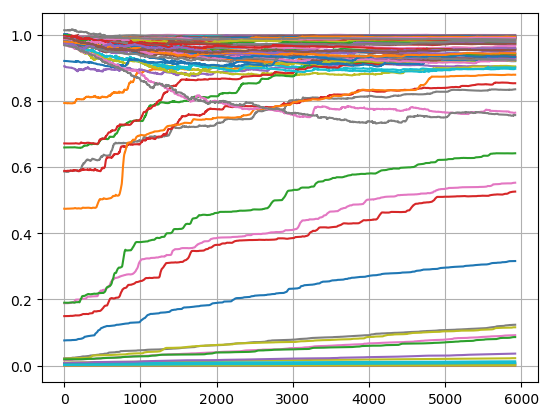

In [42]:
for k = 1:size(μ_θ_mem,2)
    plt.plot(μ_θ_mem[1:nr_samples_train,k])
    #plt.fill_between(t[bufsize:end], μ_θ_mem[1:nr_samples_train,k].+sqrt.(Σ_θ_mem[bufsize:end,k]), μ_θ_mem[bufsize:end,k].-sqrt.(Σ_θ_mem[bufsize:end,k]), alpha=0.3)
end
plt.grid()

In [56]:
y_enhanced = μ_x_mem
y_expected = [signal_t[k][end] for k = 1:nr_samples_train]
;

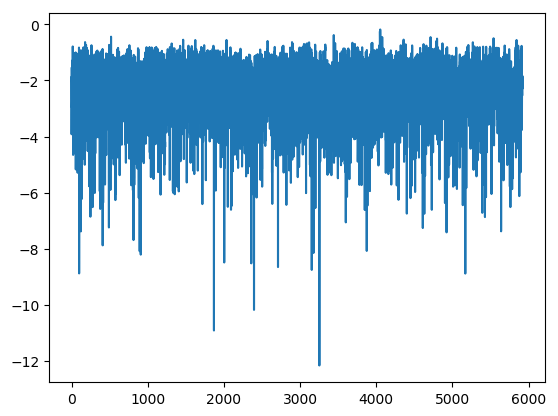

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000039D7F550>

In [57]:
plt.plot(log.(abs.(y_expected-y_enhanced)))

<source src="data:audio/wav;base64,UklGRgBeAABXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YcRdAAAnrw0+HgPhPj7yBD/6y+g+fpKtPj48pj6Mu/s9p5L4vWg3Vr29TO+95rHEvsCaq76D/de+PFYJvwD0mb47Oje+FR8KviyLMr6+IsY9zTYBPrslvT6Q2vY+6sMrPwQ1Jz+cWvE+E42rPtiABz7oD9G9l6Gkvjm3xr7H6/K+VCC4vorPf77ewo6+7VhSvsAX6b6ursi+kp2fvhmug75A/9M8qxCaPt3h+z7diB8/jgArP2y93z6AXDE/FtwEP9Pakj5W0WQ8ICeVvisZEL8+8yC/Cz42v1OrDr/x69a+XAOGvqPeQr7t2Gi9Dm/QuwvmZj1QVjg+qwTZPpL73z4q5bA+0DHPPiNAgT53snY+WgJ1Puo4gz6mGAY9bgVnvHW11b3rUqy+gdUYv0AqOL/+SCm/wGWyvmyi2b3dhEY+pSxUPpDmgz7nN2Q+XEFIPpjExD7456s+UgXCPj/6oD687zk+C2EXPhb8az2m3oi9cNvkvdglO77bhti+7K8Lv3VrPr/fB2S/z1wKv5RDk75weJI+Iy7hPh9iED9UMBk/tfUNP250Bj/S6cM+Qze5Pvq1jT5Ow4s+3i/vvF1fjr7bn6m+I4Env1k6C7+x3PO+lwTwvi3Ai74HJAy+fJQHvtCUDj0LZxQ+JHSkPQb2lz4n2AQ/flwRP3TW8T6CEyA/00L1PsGcrT4rrkI8kKSUvhzNBL/hdTO/e4ddv6ByCb/THOe+y5Fevu5t3b1DjDq9C38JPja0iD5T0/s+QGiPPsDIsj5hWqQ+xLToPrEsGj8/ONw+I63nPhxREz5Uos28NsWGvZsQAr+diy2/CNQVvxCIP78Ryka/O+z8vo2uxb6kzC6+eDtLPncpsj7HCLY+zDTePkqjXD6l9Hc+ToW/PpF+Vz5HtN8++YCAPgZy4T1JezS9H5I1vt/WB7/nc+a+FpgFv2Vj0b5NKxG+UFt4Pj+sJT4Tv5M+zJKbPiAMlj54r4s+/VSnPtuNrj2hFEY+7IU6Pngxtz2y16q9f+ITvlIomb6ncYK+hi/evqKb176hNAG/cqMpv2h0pL6RUS2+2j49PbzMwT6LL+A+217hPrE39D6uWoo+jUWhPoQnyz4jwpI+krHvPRa9UT4Drki+WSE1vsOo6zya/Ym+iUp/voYPV76wq96+BaqbvjyE674dAsi+kzlQvk70ZD6Bn8E+wFPPPq878D4Fa70+E2WUPqmfiz4qO/g8V+WDvfkhKr4lGcu+6RipvjTQmL4dclq+xjsPvpIrXL2IMTw9KxCBPdolhz4Gpys+jwdsPcQHaDwQ15w+VlEFP3zzDj5nQ0c+FKE9PSVFBr51t7o9p5ISvs826L7wyt++A6nSvsKZH7+Xbpu+q2UCvk+szT3mNL0+NzASP4JC6D5iGgE//cEJPjrYDT0ypKY8JKlYPjlEWD4aISE+z9PzvabZnL7+Xee+04sVvvWPvb3F+km+9vL8vbDdqr7XG+a+A4iQvlsnH753d6I9ZuqMPrWa2T7T8ew+qjLTPqTaEj51rYc+ECfLPvq4jj4hn9U9kkoRvnxfbL7d3ta+eqv9vvBl876JJ96+m59rvnVlYDwyUxC+QxQCvsjfjryst+o98wRJPpqL3z4GnKY+K+4yPtXolT5QPaQ+rjSBPsZDNT4UO+k9KT3zvCg1Sr6mPJa+1suqvmwnxb7yjJu+cuBNvpdKb73isRA+KP4pvf/h870AQca9cQLVveMHnj7npI4+V6KVPl6uiT5VZ00+rH9cPgPIhD0d8809OJ08vu/QE76ew4G+Jiedvh7Qm77+YpW+aBNtvhCnlr2sesw9aGKAPugMcL1jHY09mFezPI4tYD7v7g0/EtfqPvtcYT7jXUk++28Avsi2O75Rihm+dKInvlFXAL8c1RC/BwwHv6AJxb6YEAK+H5fPPcnumD4XGv4+O9UWPxigkj5v25c9y0o7vn0mHr1GaEI+fCbsPtNjbj7/4/A9htCkPHsaG742yxi98QcuvkMxzL5KDhG/QOUiv0cmDb+9CoC+1QRjPsCOzz720Qw/T+fAPrUX4D5o03k+tG0ePIC3VL48pZy+HBBUvrQXLz1UMxU9KOrVPdYKjz3a74K+4YMkPAlz4b0czN68XNa1vV1BFb5CZei97iPPvZdsQD2V8Tg+Mu3hPuWHAT+ZHes+U6r7Pd82sD188sS9chPDvlR8pr4ou1q+vacpvkMtR77ut6q+UA4Kv3NTib4VxyQ8+z98PhJFAj9ooSY+/ifkPWCeu70hYp09qC6GPgUvtj4/Nao+vsIhPqSRyz2ST6E8y73ZvUNwlT1ZZ16+Kzu9vkpDFb9H6IW+FpDJvuSv/L43WLG8vp+JPshZIT+RF1M/f8TpPnEIJbxzXgu+ymIfvtfSjL0mDog9kyLhvKkMA763NqW8ihWrPDOGXj0kxDA+6plLvlj2qL5UMai+3t6hvk6DS74Bjxi+pg5RPqXNdz60pdw+cj/1Pjc/JT4Ne9C9ZuyNvod7s75LTlW9+4N7PjLHZT5e7AQ96KbfvTIBwL39RZ++tcs/vnBQH74gqeO976iIvtpYaL2isg4+GUfEPtoAFD9H29A+HgjYPnAhvD5yADG+kVZkvmWY5b4aodS+J32Kve+7jz5dvmI+f5Pyu3P0E77X7gq/9ijnvk1MIr69pxG+22QqPSj5vD1m79E9z/5APiN8Dj6N2p8+tv+yPaOWZT7wip0+9bMfPQax5708A5i9epmIvqCgc73aiPA9MlO3vD+IJb7cug6+EW7Dvk3/674V4uy6+PSbPmCvAz8dhf4+u5ZNPhPsR71a6o++uxuQvtLzF77oNaG6LJZ9PmEIiT6TCqM+mf8EvjBcwb7RQqi+zzmOvp0XVb6tJMS9mHs+vvvOdr6d6AY9F++kPmWt5T4BDCo/LmfgPqZBXz4265E8SYKcvZNaOL6hwf29o+czvmocQr3mD828hZG7vfxNUr6lhcy+TASovlP2mb5n5z69QrMGPkDTsj7Wwbg98yNSPshvDT5mcyE+uJY3Pv+kQz7Qllk9BuH5PZmmsL2Q+yK+/xZivn4Gqb4whzW+zBjIvViwzTuhOY49SNyRPQgu8rytT6S9YOYAvfJBDD4ylrI+4qS9PlmXiD0co6G8I1X3PYS+Gj5tYwM930PwvIa1Yr3kPQi+viqAvjvQhr446+W+DTgYvmErkL73TN08+l6WPl5wxz0584W9fop1vLaU4ruY19I9NlvPPluHjT4vmVg+NdIWPavgS74/f+y8jD69PTusEL2ynQQ+ZqhIvXUbq77Xrke+TlWYvqW4fb5Asxy8Ybs3Pmizsj4BHrA+8MLLPYczt72FDZW77NpovHvkpT49O+49WZvDPQDQEr6znL6+dwjFvoOEO75f3CO+YvsgvgsjbDzrbpI8i0e7PVYhHj3PRRk+vg+8PVIObz45PFI93R7rPbV3sL336JW9PJH1vdmvfD2jjxU+DJBsPvPIUz7Ed9q9HmSavY9Cv72Rj9O+9SZ5vrGXu70J0py9QRqaPc9EoT2Tk2S9TCgBPqk5gj434o0+4R3bPjmSrj4k3bo9V47NvQw8jb4Retu+BNmkvfhJ3L1SpOo9fxrzvYMzwb4JmtG+tZOKvj32V75hHEo+3U0VP0YTvT4dK7w+pY02PpfT6bygwti8rRdHPk5Jxz4IeIU+NfoBPpZAZL4QEAK/ew39vk1oor4KcQO+iHSSPfoZer3QtLS+z5WmvtTMyb4/L2S98HCDPvxqHD9XdyY/WGoOP9Vg2D0+MDq9g436vdwoab5brSO+dGmsPJEaqT19smO909+hvY0WHr6EdHO9Mg4YvSD0Wz18ni2+r3qlvltkYL5erFS+2KfnPQQn4z6pmxg/s6EOP1xh4D6+l

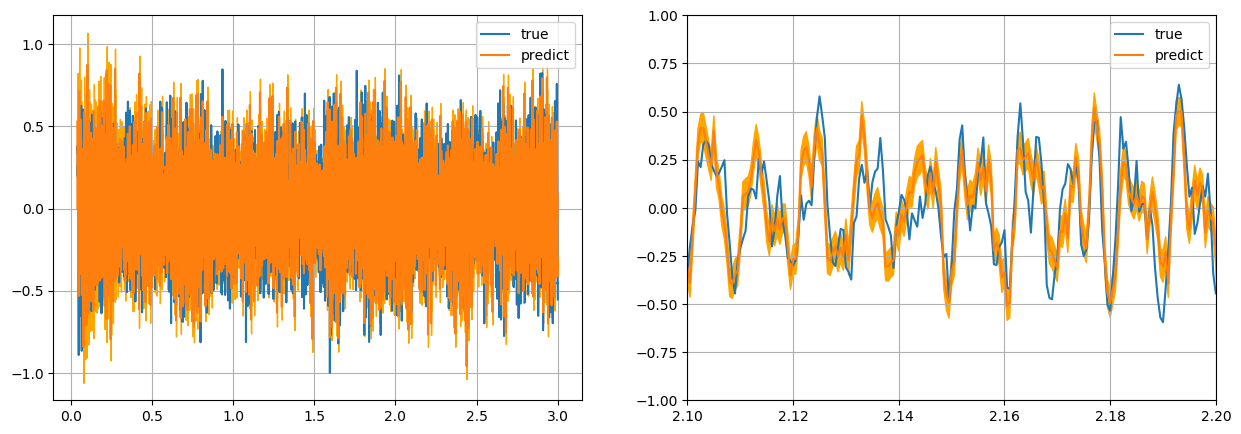

In [58]:
_, ax = plt.subplots(ncols=2, figsize=(15,5))
ax[1].plot(t[bufsize+1:end], y_expected, label="true")
ax[1].plot(t[bufsize+1:end], y_enhanced, label="predict")
ax[1].fill_between(t[bufsize+1:end], μ_x_mem .+ sqrt.(Σ_x_mem), μ_x_mem .- sqrt.(Σ_x_mem), color="orange")
ax[1].grid(), ax[1].legend()
ax[2].plot(t[bufsize+1:end], y_expected, label="true")
ax[2].plot(t[bufsize+1:end], y_enhanced, label="predict")
ax[2].fill_between(t[bufsize+1:end], μ_x_mem .+ sqrt.(Σ_x_mem), μ_x_mem .- sqrt.(Σ_x_mem), color="orange")
ax[2].grid(), ax[2].legend(), ax[2].set_xlim(2.1,2.2), ax[2].set_ylim(-1,1)
audioplayers(yi, y_enhanced, fs=fs*4)

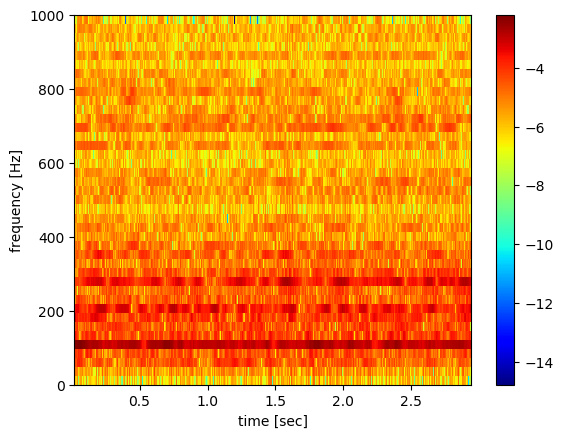

PyObject <matplotlib.colorbar.Colorbar object at 0x000000003880DCC0>

In [59]:
plot_spectrogram(spectrogram(y_enhanced, bufsize, bufsize-stepsize, fs=fs), fs)
plt.colorbar()

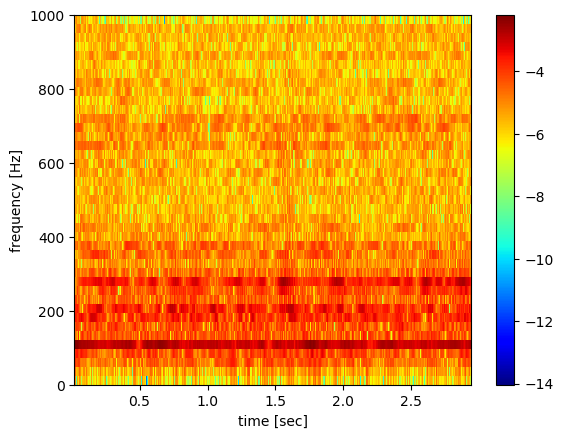

PyObject <matplotlib.colorbar.Colorbar object at 0x00000000648F2198>

In [60]:
plot_spectrogram(spectrogram(y_expected, bufsize, bufsize-stepsize, fs=fs), fs)
plt.colorbar()

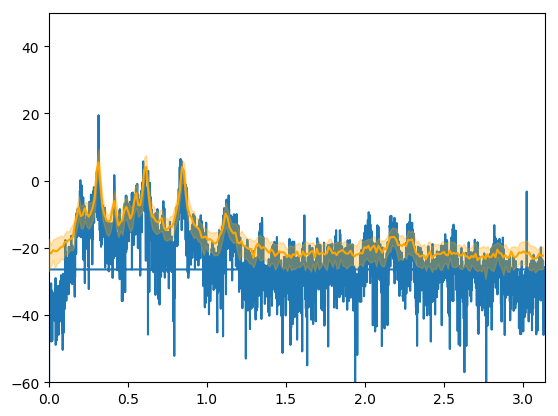

In [47]:
# generation:
Ni = 500 # (nr samples + frequency resolution)
Mi = 100 # nr of iterations

# get parameters ForneyLab.unsafeMean(marginals[:θ])
μ_θi, Σ_θi = ForneyLab.unsafeMean(marginals[:θ]), ForneyLab.unsafeCov(marginals[:θ])
v_wi, nu_wi = marginals[:w].params[:v], marginals[:w].params[:nu]


function generate1psd(μ_θi, Σ_θi, v_wi, nu_wi, N, fs, f)
    # create signal (option 1)
    sif = Array{Float64,2}(undef, 2*length(f), N)
    xif = Array{Float64,1}(undef, N)
    sif[:,1] = zeros(2*length(f))
    xif[1] = 0
    for n = 2:N
        θs = rand(MvNormal(μ_θi, collect(Hermitian(Σ_θi))))
        ws = rand(MvNormal(zeros(2*length(f)), collect(Hermitian(inv(rand(Distributions.Wishart(nu_wi, collect(Hermitian(v_wi)))))))))
        sif[:,n] = θs.*sif[:,n-1] + ws
        xif[n] = collect(sif[:,n]'*reshape( [cos.(2*pi*f/fs*n') sin.(2*pi*f/fs*n')]', 1, 2*length(f))')[1,1]
    end
    return xif
end

function approxpsd(M, μ_θi, Σ_θi, v_wi, nu_wi, N, fs, f)
    psd = Array{Float64,2}(undef, M, N) 
    for m = 1:M
        xif = generate1psd(μ_θi, Σ_θi, v_wi, nu_wi, N, fs, f)
        psd[m,:] = (abs.(FFTW.fft(xif)).^2)./length(xif)
    end
    return squeeze(10*log10.([quantile(psd[:,k], 0.5) for k = 1:N])), squeeze(10*log10.([quantile(psd[:,k], 0.25) for k = 1:N])), squeeze(10*log10.([quantile(psd[:,k], 0.75) for k = 1:N]))
end

mean_psd, std_psd1, std_psd2 = approxpsd(Mi, μ_θi, Σ_θi, v_wi, nu_wi, Ni, fs/stepsize, f)
mean_psd = mean_psd[1:Int(floor(Ni/2))]
std_psd1 = std_psd1[1:Int(floor(Ni/2))]
std_psd2 = std_psd2[1:Int(floor(Ni/2))]
plt.plot(FFTW.fftfreq(length(yi), fs)/fs*2*pi, 10*log10.((abs.(FFTW.fft(yi)).^2)./length(yi)))
plt.plot(abs.(FFTW.fftfreq(Ni, fs)[1:Int(floor(Ni/2))])/fs*2*pi, mean_psd, color="orange")
plt.fill_between(abs.(FFTW.fftfreq(Ni, fs)[1:Int(floor(Ni/2))])/fs*2*pi, std_psd1, std_psd2, color="orange", alpha=0.3, zorder=100)
plt.xlim(0,pi)
plt.ylim(-60,50)
;

In [61]:
x_true = y_expected
x_μ_pred = y_enhanced[1:end]
x_σ_pred = sqrt.(abs.(Σ_x_mem[1:end]));

In [62]:
MSE = mean(abs2.(x_true - x_μ_pred))
MAE = mean(abs.(x_true - x_μ_pred))
BME = mean([logpdf(Normal(x_μ_pred[k], x_σ_pred[k]), x_true[k]) for k = 1:length(x_true)])

MSE, MAE, BME

(0.03607260850971828, 0.15243898872023562, -1.0561652905963959)

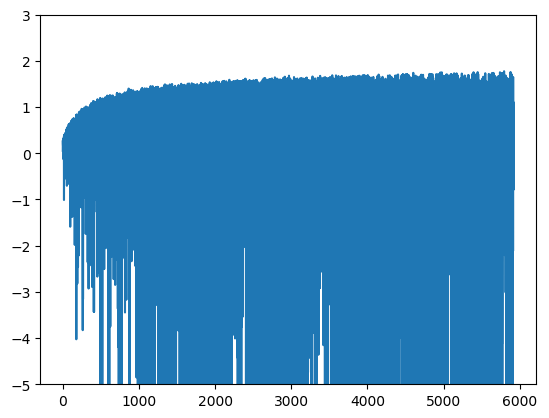

(-5, 3)

In [63]:
plt.plot([logpdf(Normal(x_μ_pred[k], x_σ_pred[k]), x_true[k]) for k = 1:length(x_true)])
plt.ylim(-5,3)